In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diamond-price-prediciton-2024/train.csv
/kaggle/input/diamond-price-prediciton-2024/test.csv


# work pipeline
1. [Get the data](#s1)
1. [Explore and visualize the data to gain insight](#s2)
1. [prepare the data](#s3)
1. [select and train a model](#s4)
    1. [LinearRegression](#ln)
    1. [RandomForestRegressor](#rf)
    1. [GradientBoostingRegressor](#GBR)
1. [fine tune and evaluate the model](#s5)
    1. [fine tune RandomForestRegressor](#fnrf)
    1. [GradientBoostingRegressor](#fnGBR)
1. [submit the result](#s6)

# Get the data
<a id="s1"></a>

download the data

In [2]:
data = pd.read_csv('/kaggle/input/diamond-price-prediciton-2024/train.csv')
submit_data = pd.read_csv('/kaggle/input/diamond-price-prediciton-2024/test.csv')

In [3]:
data.shape

(43152, 11)

we need to get testset befor doing any thing 

split the data to 80% trainset and 20% testset 

In [4]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(data , test_size=0.2, random_state=42)

# Explore and visualize the data to gain insight
<a id="s2"></a>

In [5]:
train.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
21805,21806,1.55,Premium,J,VS1,62.6,59.0,8749,7.40,7.35,4.62
22939,22940,1.04,Premium,G,I1,62.2,58.0,2801,6.46,6.41,4.00
33888,33889,1.22,Premium,G,VS2,61.8,58.0,8362,6.91,6.84,4.25
35779,35780,0.51,Ideal,H,IF,62.6,56.0,1920,5.10,5.13,3.20
20589,20590,0.41,Ideal,E,SI1,62.1,54.0,969,4.81,4.76,2.97


In [6]:
train.shape

(34521, 11)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34521 entries, 21805 to 15795
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       34521 non-null  int64  
 1   carat    34521 non-null  float64
 2   cut      34521 non-null  object 
 3   color    34521 non-null  object 
 4   clarity  34521 non-null  object 
 5   depth    34521 non-null  float64
 6   table    34521 non-null  float64
 7   price    34521 non-null  int64  
 8   x        34521 non-null  float64
 9   y        34521 non-null  float64
 10  z        34521 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.2+ MB


In [8]:
train.describe()

,Id,carat,depth,table,price,x,y,z
count,34521.000000,34521.000000,34521.000000,34521.000000,34521.000000,34521.000000,34521.000000,34521.000000
mean,21621.709771,0.797798,61.751221,57.466418,3931.306480,5.729599,5.732268,3.537777
std,12444.427233,0.475239,1.435461,2.230899,3998.158239,1.124250,1.124616,0.713282
min,3.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10846.000000,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000
50%,21637.000000,0.700000,61.800000,57.000000,2394.000000,5.690000,5.700000,3.520000
75%,32438.000000,1.040000,62.500000,59.000000,5302.000000,6.540000,6.540000,4.040000
max,43152.000000,5.010000,79.000000,95.000000,18803.000000,10.740000,31.800000,31.800000


In [9]:
train.describe(include = object)

,cut,color,clarity
count,34521,34521,34521
unique,5,7,8
top,Ideal,G,SI1
freq,13691,7216,8312


from describe table we can see that the min value in the columns x,y,z  is 0. 
since these features represent lengths, so zero values in this columns represent null values.

In [10]:
print("null values in x column :" , sum(train['x'] == 0))
print("null values in y column :" , sum(train['y'] == 0))
print("null values in z column :" , sum(train['z'] == 0))

null values in x column : 5
null values in y column : 4
null values in z column : 14


In [11]:
print("number of samples with null values : " , sum((train['x'] == 0) | (train['y'] == 0) | (train['z'] == 0)))

number of samples with null values :  14


In [12]:
train[(train['x'] == 0) | (train['y'] == 0) | (train['z'] == 0)]

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
24901,24902,2.25,Premium,H,SI2,62.8,59.0,18034,0.00,0.00,0.0
1221,1222,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
22171,22172,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.0
39201,39202,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.0
571,572,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0
27221,27222,1.12,Premium,G,I1,60.4,59.0,2383,6.71,6.67,0.0
4980,4981,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0
903,904,2.25,Premium,I,SI1,61.3,58.0,15397,8.52,8.42,0.0
34065,34066,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0
13727,13728,2.02,Premium,H,VS2,62.7,53.0,18207,8.02,7.95,0.0


this is all the samples with null values

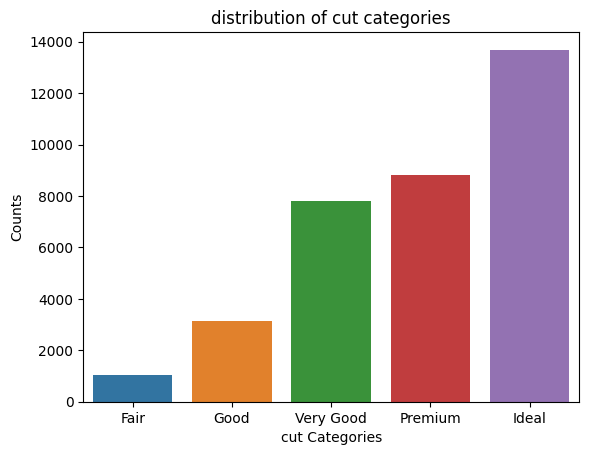

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns 
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
sns.countplot(x=train.cut,
             order=cut_order)  
plt.xlabel("cut Categories")
plt.ylabel("Counts")
plt.title("distribution of cut categories")
plt.show()

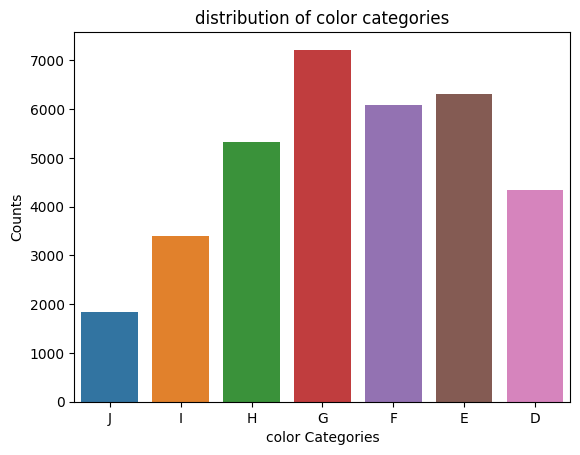

In [14]:
color_order = ['J' , 'I' , 'H' , 'G' ,'F','E' , 'D']
sns.countplot(x=train.color,
             order = color_order)  
plt.xlabel("color Categories")
plt.ylabel("Counts")
plt.title("distribution of color categories")
plt.show()

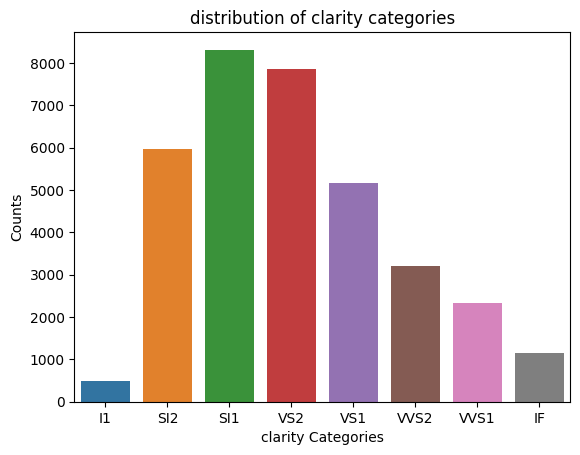

In [15]:
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
sns.countplot(x=train.clarity,
             order = clarity_order)  
plt.xlabel("clarity Categories")
plt.ylabel("Counts")
plt.title("distribution of clarity categories")
plt.show()

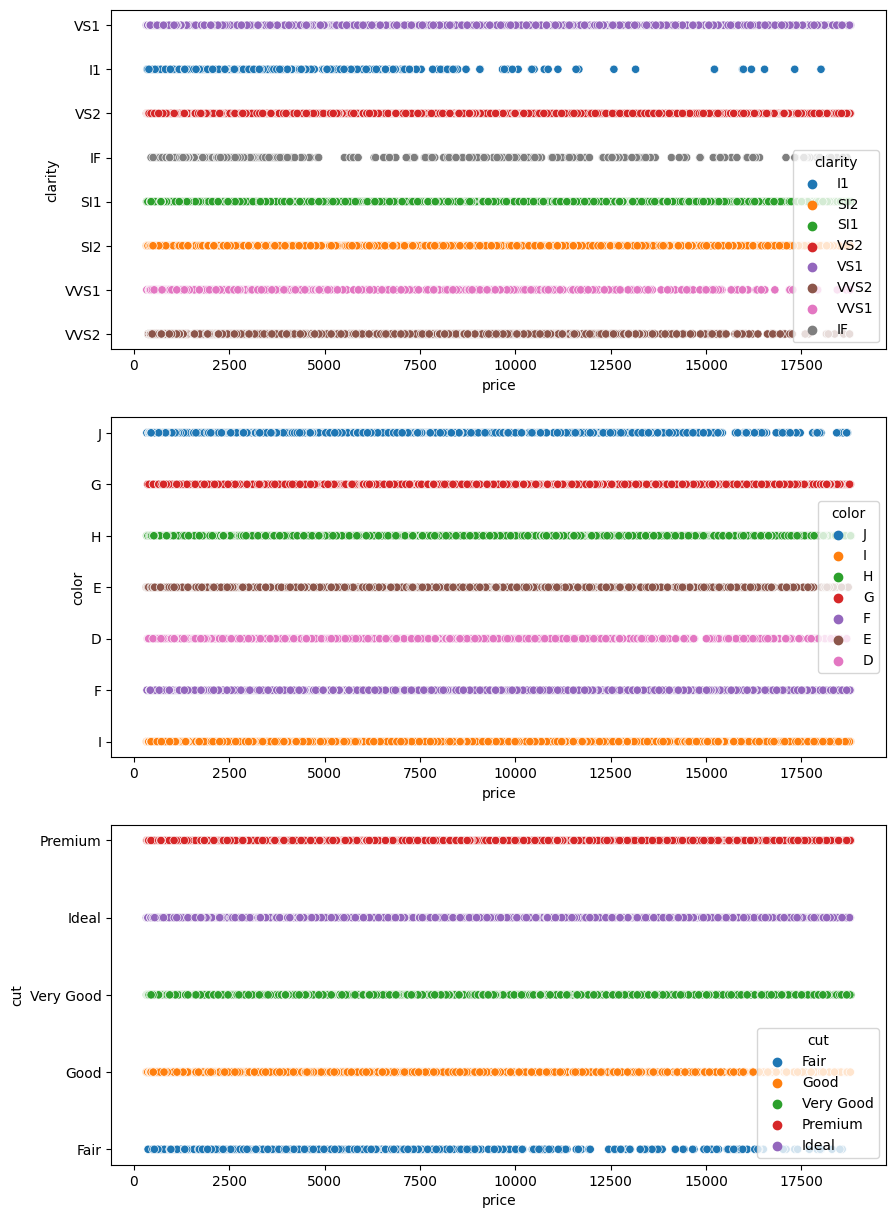

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))


sns.scatterplot(x='price',
                y='clarity' ,
                hue='clarity',
                data=train ,
                hue_order = clarity_order,
                ax = axes[0])


sns.scatterplot(x='price',
                y='color' ,
                hue='color',
                data=train ,
                hue_order = color_order,
                ax=axes[1])



sns.scatterplot(x='price',
                y='cut' ,
                hue='cut',
                data=train ,
                hue_order = cut_order,
                ax = axes[2])




plt.show()

the previos plot shows the relation between the price and categorical featureas.
there isn't any good or clear relation between price and cut,color,clarity columns

In [17]:
corr_matrix = train.select_dtypes(include='number').drop('Id' , axis = 1).corr()
corr_matrix

,carat,depth,table,price,x,y,z
carat,1.000000,0.027980,0.179536,0.921341,0.975090,0.966588,0.944079
depth,0.027980,1.000000,-0.306303,-0.010972,-0.025844,-0.028565,0.093901
table,0.179536,-0.306303,1.000000,0.126465,0.193843,0.185684,0.146656
price,0.921341,-0.010972,0.126465,1.000000,0.884537,0.879284,0.852939
x,0.975090,-0.025844,0.193843,0.884537,1.000000,0.990018,0.961552
y,0.966588,-0.028565,0.185684,0.879284,0.990018,1.000000,0.954858
z,0.944079,0.093901,0.146656,0.852939,0.961552,0.954858,1.000000


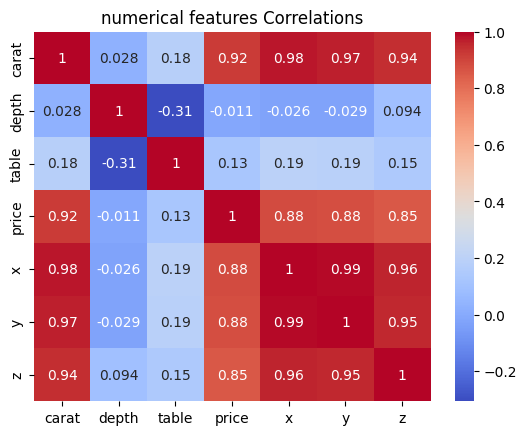

In [18]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')  
plt.title("numerical features Correlations")
plt.show()

In [19]:
train['size'] = train['x'] * train['y'] * train['z']

In [20]:
corr_matrix2 = train.select_dtypes(include='number').drop('Id' , axis = 1).corr()
corr_matrix2

,carat,depth,table,price,x,y,z,size
carat,1.000000,0.027980,0.179536,0.921341,0.975090,0.966588,0.944079,0.993640
depth,0.027980,1.000000,-0.306303,-0.010972,-0.025844,-0.028565,0.093901,0.010534
table,0.179536,-0.306303,1.000000,0.126465,0.193843,0.185684,0.146656,0.169071
price,0.921341,-0.010972,0.126465,1.000000,0.884537,0.879284,0.852939,0.918455
x,0.975090,-0.025844,0.193843,0.884537,1.000000,0.990018,0.961552,0.974004
y,0.966588,-0.028565,0.185684,0.879284,0.990018,1.000000,0.954858,0.972383
z,0.944079,0.093901,0.146656,0.852939,0.961552,0.954858,1.000000,0.960128
size,0.993640,0.010534,0.169071,0.918455,0.974004,0.972383,0.960128,1.000000


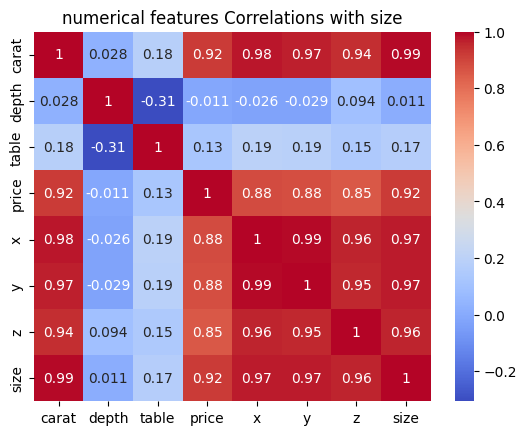

In [21]:
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm')  
plt.title("numerical features Correlations with size")
plt.show()

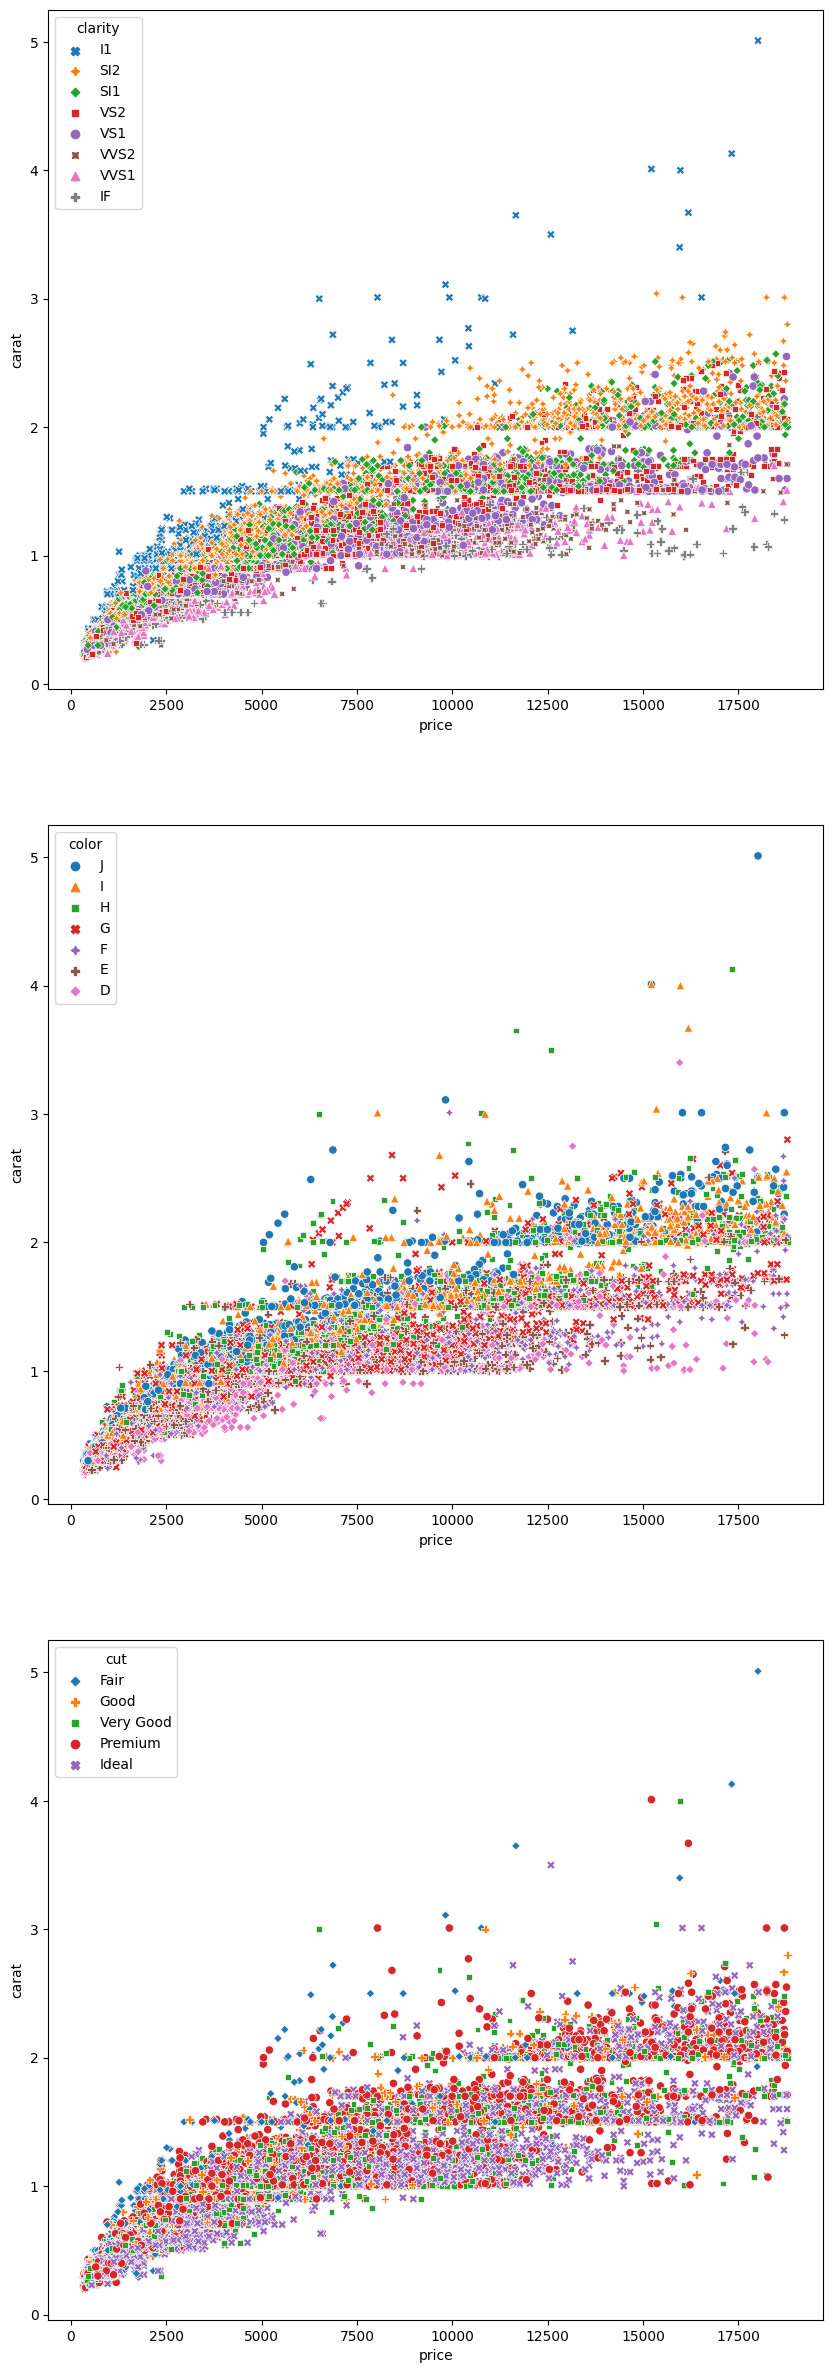

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(10, 30))


sns.scatterplot(x='price',
                y='carat' ,
                hue='clarity',
                style = 'clarity',
                data=train ,
                hue_order = clarity_order,
                ax = axes[0])



sns.scatterplot(x='price',
                y='carat' ,
                hue='color',
                style = 'color',
                data=train ,
                hue_order = color_order,
                ax=axes[1])



sns.scatterplot(x='price',
                y='carat' ,
                hue='cut',
                data=train ,
                hue_order = cut_order,
                style = 'cut',
                ax = axes[2])




plt.show()

<Axes: xlabel='table', ylabel='depth'>

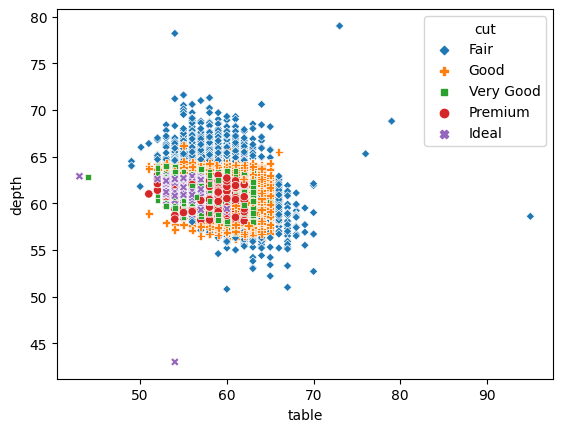

In [23]:
sns.scatterplot(x='table',
                y='depth' ,
                
                hue='cut',
                data=train ,
                hue_order = cut_order,
                style='cut',
           )



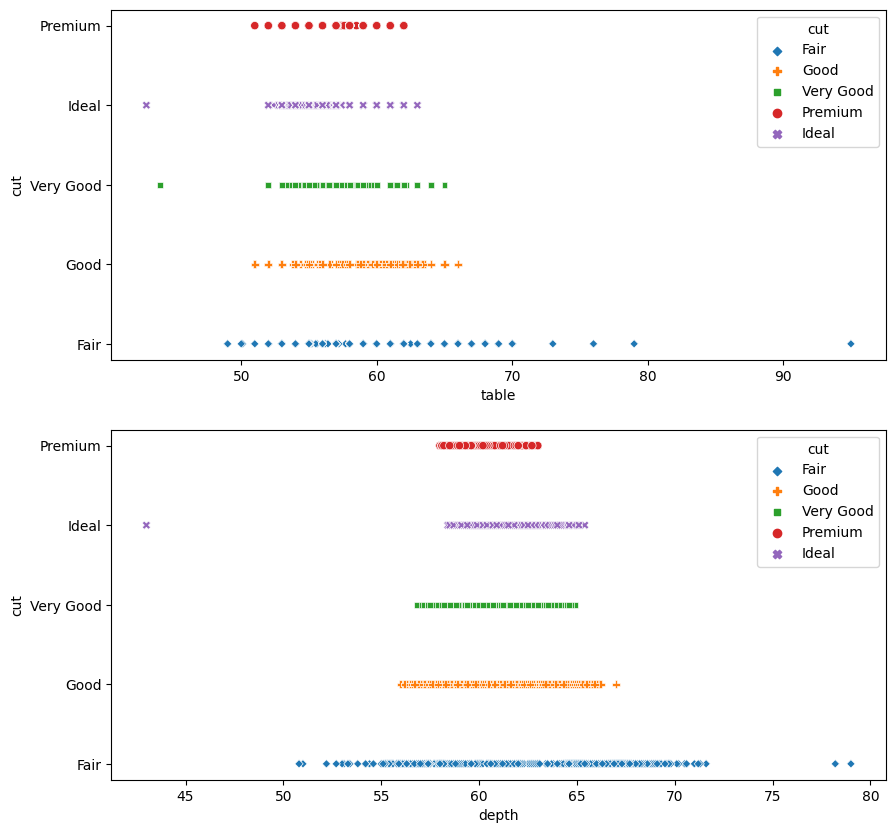

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))


sns.scatterplot(x='table',
                y='cut' ,
                hue='cut',
                style = 'cut',
                data=train ,
                hue_order = cut_order,
                ax = axes[0])


sns.scatterplot(x='depth',
                y='cut' ,
                hue='cut',
                style = 'cut',
                data=train ,
                hue_order = cut_order,
                ax=axes[1])



plt.show()

<Axes: xlabel='z', ylabel='carat'>

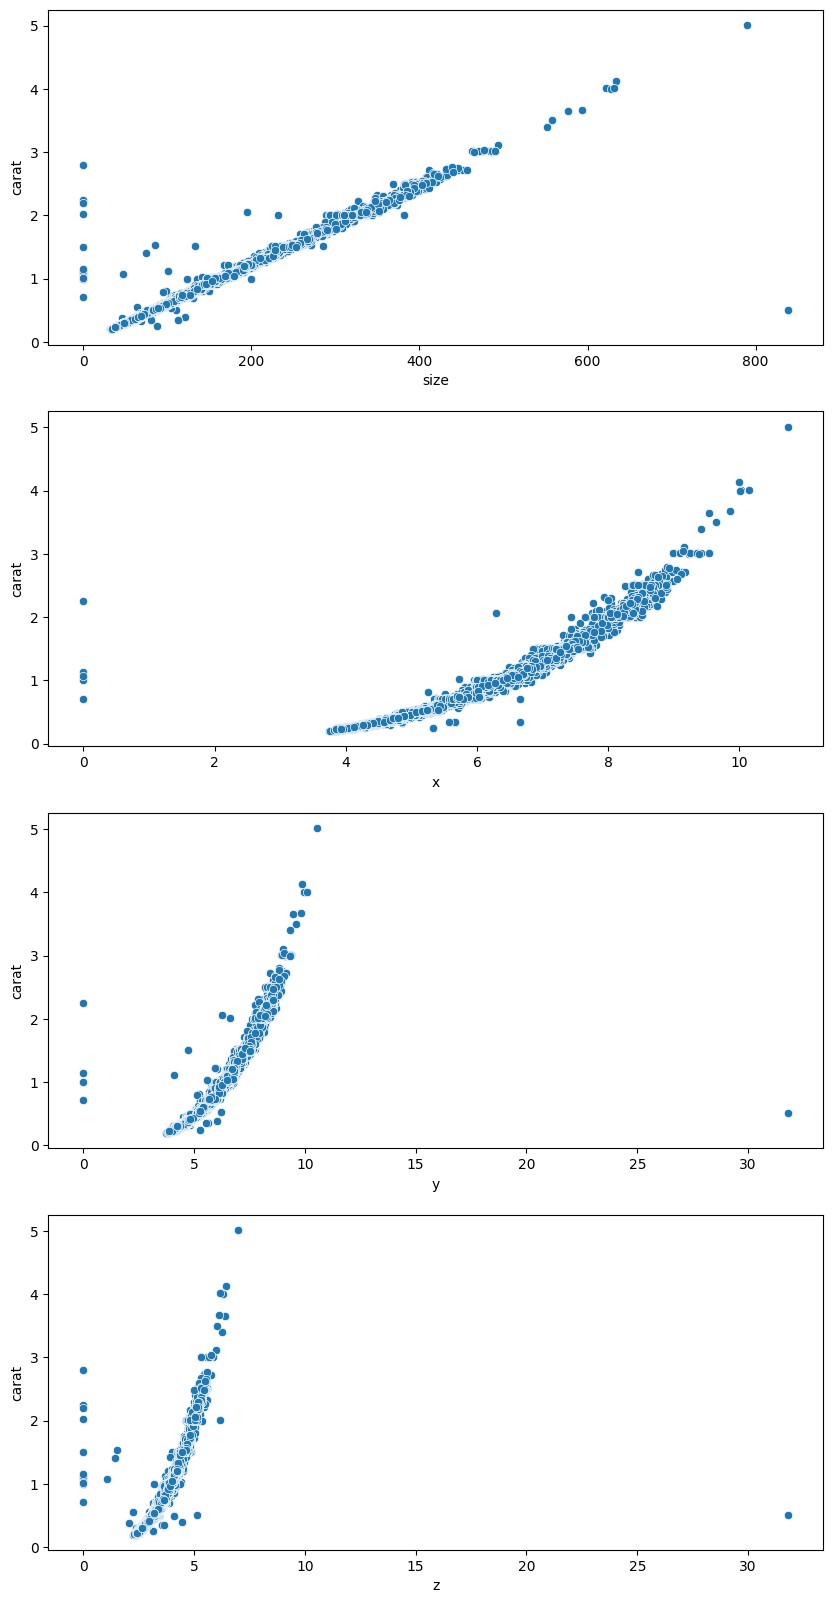

In [25]:
gig, axes = plt.subplots(4, 1, figsize=(10, 20))
sns.scatterplot(x='size',
                y='carat' ,
                data=train ,
                ax=axes[0]
                )
sns.scatterplot(x='x',
                y='carat' ,
                data=train ,
                ax=axes[1]
                )
sns.scatterplot(x='y',
                y='carat' ,
                data=train ,
                ax=axes[2]
                )
sns.scatterplot(x='z',
                y='carat' ,
                data=train ,
                ax=axes[3]
                )


<Axes: xlabel='clarity', ylabel='price'>

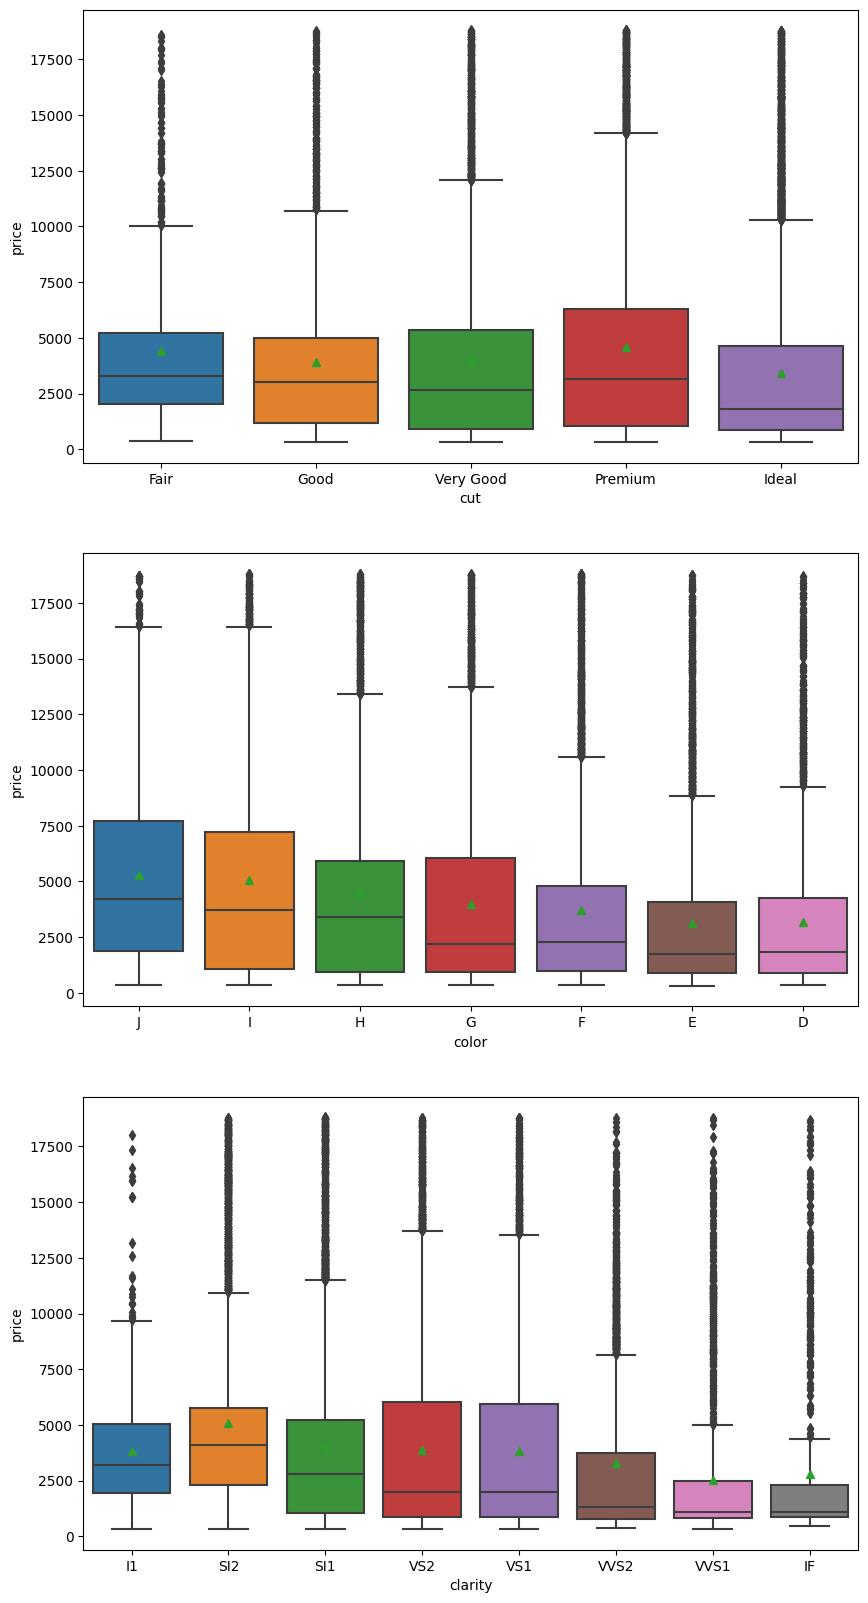

In [26]:
gig, axes = plt.subplots(3, 1, figsize=(10, 20))
sns.boxplot(x='cut',
                y='price' ,
                order = cut_order,
                showmeans=True,
                data=train ,
                ax=axes[0]
                )
sns.boxplot(x='color',
                y='price' ,
                order = color_order,
                showmeans=True,
                data=train ,
                ax=axes[1]
                )
sns.boxplot(x='clarity',
                y='price' ,
                order = clarity_order,
                showmeans=True,
                data=train ,
                ax=axes[2]
                )


In [27]:
# from sklearn.decomposition import PCA


# pca = PCA(n_components=2) 

# pca.fit(train[['carat' , 'depth', 'table' ,'x' , 'y' ,'z', 'size']])


# df_pca = pca.transform(train[['carat' , 'depth', 'table' ,'x' , 'y' ,'z', 'size']])

# sns.scatterplot(x= 0,
#                 y= 1 ,
#                 data=df_pca ,
             
#                 )

# prepare the data 
<a id="s3"></a>

In [28]:
def remove_outliers(df , feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    mask = (df[feature] > lower_bound) & (df[feature] < upper_bound)
    
    return df[mask]

In [29]:
columns = train.columns
columns

Index(['Id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price',
       'x', 'y', 'z', 'size'],
      dtype='object')

In [30]:
X_col = [ 'cut', 'color', 'clarity','carat' , 'depth', 'table' , 'size']

In [31]:
for i in X_col[3:]:
    train = remove_outliers(train, i)

In [32]:
X_train = train[X_col].copy()
y_train = train['price'].copy() 

<Axes: >

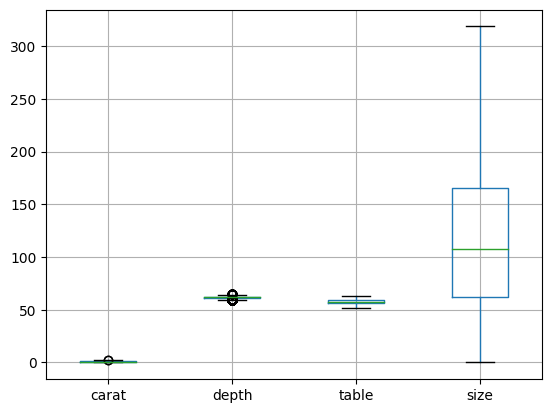

In [33]:
X_train.boxplot()

In [34]:
X_train.shape

(30967, 7)

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [36]:
num_attribs = X_col[3:]
cat_attribs = X_col[:3]

num_pipeline = Pipeline([
 ("standardize", MinMaxScaler()),
])

# encoders = {
#     "cut": OrdinalEncoder(categories=[cut_order]),  
#     "color": OrdinalEncoder(categories=[color_order]),
#     "clarity": OrdinalEncoder(categories=[clarity_order]),
# }

transformer = ColumnTransformer(transformers=[
    ("cut", OrdinalEncoder(categories=[cut_order] ) , ['cut']),  
    ("color", OrdinalEncoder(categories=[color_order]) , ['color']),
    ("clarity", OrdinalEncoder(categories=[clarity_order]) , ['clarity']),
    ])
cat_pipeline = Pipeline([
#     ('ohe' , OneHotEncoder(sparse_output = False)),
 ('ordinal_encoder' , transformer),
    ("standardize", MinMaxScaler())
    
])

full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", cat_pipeline, cat_attribs),
])

In [37]:
full_pipeline.fit(X_train[X_col])
trans_X_train = full_pipeline.transform(X_train[X_col])
trans_X_train

array([[0.75418994, 0.64814815, 0.61403509, ..., 0.75      , 0.        ,
        0.57142857],
       [0.46927374, 0.57407407, 0.52631579, ..., 0.75      , 0.5       ,
        0.        ],
       [0.5698324 , 0.5       , 0.52631579, ..., 0.75      , 0.5       ,
        0.42857143],
       ...,
       [0.05586592, 0.66666667, 0.70175439, ..., 0.75      , 1.        ,
        0.28571429],
       [0.72625698, 0.05555556, 0.70175439, ..., 1.        , 0.16666667,
        0.28571429],
       [0.11731844, 0.44444444, 0.43859649, ..., 1.        , 0.5       ,
        0.85714286]])

In [38]:
test['size'] = test['x'] * test['y'] * test['z']
X_test = test[X_col].copy()
y_test = test['price'].copy() 

trans_X_test = full_pipeline.transform(X_test[X_col])

# select and train a model
<a id="s4"></a>

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from tensorflow import keras
from sklearn.model_selection import GridSearchCV

2024-05-15 08:30:16.647284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 08:30:16.647340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 08:30:16.648799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## LinearRegression
<a id = 'ln'></a>

In [40]:
# poly = PolynomialFeatures(degree=2, include_bias=False) 
# X_poly = poly.fit_transform(trans_X_train)
# x_poly_test = poly.transform(trans_X_test)

In [43]:
lin_model = LinearRegression()

lin_model.fit(trans_X_train, y_train)

train_pred = lin_model.predict(trans_X_train)


mse = mean_squared_error(y_train, train_pred)
print("Mean squared error:", mse)
print("Root Mean squared error:", np.sqrt(mse))

test_pred = lin_model.predict(trans_X_test)
test_mse = mean_squared_error(y_test , test_pred)
print("Mean squared error:", test_mse)
print("Root Mean squared error:", np.sqrt(test_mse))

Mean squared error: 1199844.090651893
Root Mean squared error: 1095.3739501430061
Mean squared error: 1908434.7673391253
Root Mean squared error: 1381.461098742605


## RandomForestRegressor
<a id = 'rf'></a>

In [44]:
forect_model = RandomForestRegressor(n_estimators=100, random_state=42)
forect_model.fit(trans_X_train, y_train)

train_pred = forect_model.predict(trans_X_train)
mse = mean_squared_error(y_train, train_pred)
print('Train set')
print("Mean squared error:", mse)
print("Root Mean squared error:", np.sqrt(mse))

test_pred = forect_model.predict(trans_X_test)
test_mse = mean_squared_error(y_test, test_pred)
print('Test set')
print("Mean squared error:", test_mse)
print("Root Mean squared error:", np.sqrt(test_mse))

Train set
Mean squared error: 26340.736163018584
Root Mean squared error: 162.29829377728709
Test set
Mean squared error: 581692.5249431356
Root Mean squared error: 762.687698172152


## GradientBoostingRegressor
<a id = 'GBR'></a>

In [45]:
GBR_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.5, max_depth=10)
GBR_model.fit(trans_X_train, y_train)

train_pred = GBR_model.predict(trans_X_train)
mse = mean_squared_error(y_train , train_pred )
print('Train set')
print("Mean squared error:", mse)
print("Root Mean squared error:", np.sqrt(mse))

test_pred = GBR_model.predict(trans_X_test)
test_mse = mean_squared_error(y_test , test_pred )
print('Test set')
print("Mean squared error:", test_mse)
print("Root Mean squared error:", np.sqrt(test_mse))

Train set
Mean squared error: 1134.9362598745156
Root Mean squared error: 33.688815055957605
Test set
Mean squared error: 613049.3910261567
Root Mean squared error: 782.9747065047227


In [46]:
xgb_model = XGBRegressor(n_estimators=150, learning_rate=0.1 ,) 
xgb_model.fit(trans_X_train, y_train)

train_pred = xgb_model.predict(trans_X_train)
mse = mean_squared_error(y_train , train_pred )
print('Train set')
print("Mean squared error:", mse)
print("Root Mean squared error:", np.sqrt(mse))

test_pred = xgb_model.predict(trans_X_test)
test_mse = mean_squared_error(y_test , test_pred )
print('Test set')
print("Mean squared error:", test_mse)
print("Root Mean squared error:", np.sqrt(test_mse))

Train set
Mean squared error: 111772.4287797025
Root Mean squared error: 334.32383818642444
Test set
Mean squared error: 554231.6459432526
Root Mean squared error: 744.4673572046344


# fine tune and evaluate the model
<a id="s5"></a>

## fine tune RandomForestregressor
<a id = 'fnrf'></a>

In [47]:
RF_param_grid = {
    'n_estimators': [200 , 300 , 400 ],
    'max_depth': [8 , 10 , 15 ],
}


RF_grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=RF_param_grid, cv=10 , scoring='neg_mean_squared_error')


RF_grid_search.fit(trans_X_train, y_train)

RF_best_model = RF_grid_search.best_estimator_
RF_best_params = RF_grid_search.best_params_
print(RF_best_params)
print()

train_pred = RF_best_model.predict(trans_X_train)
mse = mean_squared_error(y_train, train_pred)
print('Train set')
print("Mean squared error:", mse)
print("Root Mean squared error:", np.sqrt(mse))

test_pred = RF_best_model.predict(trans_X_test)
test_mse = mean_squared_error(y_test, test_pred)
print('Test set')
print("Mean squared error:", test_mse)
print("Root Mean squared error:", np.sqrt(test_mse))

{'max_depth': 15, 'n_estimators': 400}

Train set
Mean squared error: 40755.91696320499
Root Mean squared error: 201.8809474992749
Test set
Mean squared error: 575287.1223961564
Root Mean squared error: 758.4768436782737


## fine tune GradientBoostingRegressor
<a id = 'fnGBR'></a>

In [49]:
GBR_param_grid = {
    'n_estimators': [100 , 200 , 300 , 400 ],
    'max_depth': [8 , 10 , 15 ],
    'learning_rate': [0.05 , 0.1 , 0.3 , 0.5]
}


GBR_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=GBR_param_grid, cv=10, scoring='neg_mean_squared_error')


GBR_grid_search.fit(trans_X_train, y_train)

GBR_best_model = GBR_grid_search.best_estimator_
GBR_best_params = GBR_grid_search.best_params_
print(GBR_best_params)
print()


train_pred = GBR_best_model.predict(trans_X_train)
mse = mean_squared_error(y_train, train_pred)
print('Train set')
print("Mean squared error:", mse)
print("Root Mean squared error:", np.sqrt(mse))

test_pred = GBR_best_model.predict(trans_X_test)
test_mse = mean_squared_error(y_test, test_pred)
print('Test set')
print("Mean squared error:", test_mse)
print("Root Mean squared error:", np.sqrt(test_mse))

KeyboardInterrupt: 

In [ ]:
xgb_param_grid = {
    'n_estimators': [ 100 , 150 , 200 ,300 , 400 , 500],
    'learning_rate':[0.01 , 0.05 , 0.1 ,0.2 ]
}


xgb_grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=xgb_param_grid, cv=10, scoring='neg_mean_squared_error')


xgb_grid_search.fit(trans_X_train, y_train)

xgb_best_model = xgb_grid_search.best_estimator_
xgb_best_params = xgb_grid_search.best_params_
print(xgb_best_params)
print()

train_pred = xgb_best_model.predict(trans_X_train)
mse = mean_squared_error(y_train, train_pred)
print('Train set')
print("Mean squared error:", mse)
print("Root Mean squared error:", np.sqrt(mse))


test_pred = xgb_best_model.predict(trans_X_test)
test_mse = mean_squared_error(y_test , test_pred )
print('Test set')
print("Mean squared error:", test_mse)
print("Root Mean squared error:", np.sqrt(test_mse))

# submit the result
<a id="s6"></a>

In [ ]:
submit_data['size'] = submit_data['x'] * submit_data['y'] * submit_data['z']
X_submit = full_pipeline.transform(submit_data[X_col])
predict_submit = xgb_best_model.predict(X_submit)

In [ ]:
submition = pd.DataFrame()
submition['Id'] = submit_data['Id']
submition['price'] = predict_submit
submition.to_csv('/kaggle/working/submit.csv' , columns = ['Id' , 'price'] , index = False)